<a href="https://colab.research.google.com/github/jundev1l2l/jun-dev-1l2l/blob/master/iris_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Logistic Regression Model

- 이진 분류를 위한 로지스틱 회귀 모델을 Newton-Raphson 방법으로 학습

In [89]:
class LogisticNewton():
    def __init__(self):
        pass
    
    def fit(self, x, y, threshold=0.01, pinv=False, epochs=100, is_print=True, is_continue=False):
        """
        threshold: stopping rule considering weight convergence
        pinv: flag for using pseudo-inverse in weight updata (prevent singular matrix case)
        epochs: max epochs to update
        """
        self.threshold = threshold
        self.features = x  # [N,D]
        self.target = y  # [N,]
        N, D = x.shape

        x0 = np.concatenate((np.ones((N, 1)), x), -1) # [N,D+1] augmented x_data
        """
        initialization of weight value [important]
        (1) Normal(0, 1) --> unstable 
        (2) All 0 --> stable
        """
        if not is_continue:
            self.w = np.zeros((D+1, 1)) # [D+1,1] including bias term

        epoch = 0
        while True:
            self.pred = self.predict(x)
            self.acc = ((self.pred == y) + 0).mean()

            hessian, gradient = 0, 0
            for i, data in enumerate(x0):
                data = data.reshape(1, D+1)
                sigmoid = 1 / (1 + np.exp( - data @ self.w ))
                hessian += sigmoid * (1 - sigmoid) * np.transpose(data) @ data
                gradient += (y[i] - sigmoid) * np.transpose(data) 
            if pinv:
                dw = np.linalg.pinv(hessian) @ gradient
            else:
                dw = np.linalg.inv(hessian) @ gradient

            if (self.w > 1e5).any():
                if is_print:
                    print("weight value too large\n")
                break
            else:
                self.w += dw
            epoch += 1

            if (dw < self.w * self.threshold).all():
                if is_print:
                    print("almost no update on weight values\n")
                    self.print_result()
                break
            # if (self.w > 1e10).any():
            #     if is_print:
            #         print("weight value too large\n")
            #     break
            if self.acc == 1.0:
                if is_print:
                    print("get perfect accuracy\n")
                    self.print_result()
                break
            if epoch == epochs:
                if is_print:
                    print(f"{epochs} epochs done\n")
                    self.print_result()
                break
    
    def predict(self, x):
        N = x.shape[0]
        x0 = np.concatenate((np.ones((N,1)), x), -1)
        pred = ((x0 @ self.w) >= 0.5) + 0  # [N,1] array with {0, 1}
        return pred.squeeze() # [N,]

    def print_result(self):
        print(f"acc: {self.acc:0.4f}")
        print(self.w)
        print()

    def cv(self, x, y, threshold=1e-5, pinv=True, epochs=1000, is_print=False):
        """
        cross-validate the result
        """
        N, D = x.shape
        self.w = np.zeros((D+1, 1))

        N = x.shape[0]
        n = int(N / 10)  # number of data points per group
        index = np.arange(N)
        np.random.shuffle(index)

        groups_index = [index[10*i:10*(i+1)] for i in range(n)]  # 10-fold

        self.ACC_list = []
        self.TPR_list = []
        self.TNR_list = []
        self.ACC = []
        self.TPR = []
        self.TNR = []
        self.confusion = {"TP":0, "FP":0, "TN":0, "FN":0}

        for group_index in groups_index:

            _x = x[np.delete(index, group_index)]  # x data 90개
            _y = y[np.delete(index, group_index)]  # y data 90개
        
            for e in range(epochs):
                confusion = {"TP":0, "FP":0, "TN":0, "FN":0}
                self.fit(_x, _y, threshold, pinv, 1, is_print, is_continue=True)
                pred = self.predict(x[group_index])
                target = y[group_index]
                for i in range(n):
                    if pred[i] == 1:
                        if target[i] == 1:
                            confusion["TP"] += 1
                            self.confusion["TP"] += 1
                        else:
                            confusion["FN"] += 1
                            self.confusion["FN"] += 1
                    else:
                        if target[i] == 1:
                            confusion["FP"] += 1
                            self.confusion["FP"] += 1
                        else:
                            confusion["TN"] += 1
                            self.confusion["TN"] += 1
                
                acc = ((pred == target) + 0).mean()
                if (confusion["TP"] + confusion["FN"]) > 0:
                    tpr = confusion["TP"] / (confusion["TP"] + confusion["FN"])
                else:
                    tpr = 0
                if (confusion["TN"] + confusion["FP"]) > 0:
                    tnr = confusion["TN"] / (confusion["TN"] + confusion["FP"])
                else:
                    tnr = 0

                self.ACC_list.append(acc)
                self.TPR_list.append(tpr)
                self.TNR_list.append(tnr)

                if e == (epochs-1):
                    self.ACC.append(acc)
                    self.TPR.append(tpr)
                    self.TNR.append(tnr)
                

# Toy example

- 아주 간단한 예제로, 모델이 잘 작동하는지 확인

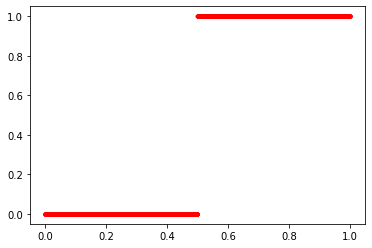

In [4]:
x_toy = np.linspace(0, 1, 10000).reshape(-1, 1)
y_toy = ((x_toy > 0.5) + 0).squeeze()

plt.plot(x_toy, y_toy.reshape(-1, 1), "r.")

In [5]:
toy_model = LogisticNewton()

toy_model.fit(x_toy, y_toy)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp


get perfect accuracy

acc: 1.0000
[[-8225.6252319 ]
 [16451.25046381]]



# Iris dataset

In [6]:
from google.colab import drive

drive.mount("./drive")

Mounted at ./drive


### CSV 파일을 `pandas.DataFrame`으로 불러오기

In [7]:
iris_data = pd.read_csv("./drive/My Drive/Colab Notebooks/logistic-newton-tutorial/iris-data.csv",
                        names=["sepal length", "sepal width", "petal length", "petal width","class"])

### `setosa` 클래스에 해당하는 데이터 삭제

In [8]:
drop_index = iris_data[iris_data["class"]=="Iris-setosa"].index

iris_data = iris_data.drop(drop_index)

### `versicolor` = 1, `virginica` = 0 으로 설정

In [9]:
change_dict = {"Iris-versicolor": 1,
               "Iris-virginica": 0}

iris_data = iris_data.replace({"class": change_dict})

In [10]:
iris_data.head()

,sepal length,sepal width,petal length,petal width,class
50,7.0,3.2,4.7,1.4,1
51,6.4,3.2,4.5,1.5,1
52,6.9,3.1,4.9,1.5,1
53,5.5,2.3,4.0,1.3,1
54,6.5,2.8,4.6,1.5,1


In [11]:
iris_data.describe()

,sepal length,sepal width,petal length,petal width,class
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,6.262000,2.872000,4.906000,1.676000,0.500000
std,0.662834,0.332751,0.825578,0.424769,0.502519
min,4.900000,2.000000,3.000000,1.000000,0.000000
25%,5.800000,2.700000,4.375000,1.300000,0.000000
50%,6.300000,2.900000,4.900000,1.600000,0.500000
75%,6.700000,3.025000,5.525000,2.000000,1.000000
max,7.900000,3.800000,6.900000,2.500000,1.000000


# Fitting + Cross-Validation

In [12]:
x_data = iris_data.loc[:, "sepal length":"petal width"].to_numpy()  #[100,4]
y_data = iris_data.loc[:, "class"].to_numpy()  # [100,]

In [125]:
model = LogisticNewton()
model.cv(x_data, y_data, threshold=1e-5, epochs=3, is_print=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp


# Evaluation

Mean Accuracy

In [126]:
ACC_list = np.array(model.ACC_list).reshape(10, 3)
print(ACC_list)

[[0.9 0.9 0.9]
 [0.9 0.9 0.9]
 [1.  1.  1. ]
 [1.  1.  1. ]
 [0.  1.  1. ]
 [1.  1.  1. ]
 [1.  1.  1. ]
 [1.  1.  1. ]
 [1.  1.  1. ]
 [1.  1.  1. ]]


In [127]:
print(f"mean accuracy: {ACC_list[:,-1].mean():.4f}")

mean accuracy: 0.9800


Confusion Matrix (averaged)

- `versicolor(1)`를 `True` label로 상정하고 평가
- 즉, `virginica(0)`는 `False` label

In [128]:
mtx = model.confusion
pd.DataFrame([[mtx["TP"], mtx["FP"]], [mtx["TN"], mtx["FN"]]],
             index=["T","F"], columns=["P","N"])

,P,N
T,138,12
F,146,4


Sensitivity (averaged)

In [129]:
print(f"sensitivity: {np.array(model.TPR_list).mean():.4f}")

sensitivity: 0.9667


Specificity (averaged)

In [130]:
print(f"specificity: {np.array(model.TNR_list).mean():.4f}")

specificity: 0.9133


ROC curve

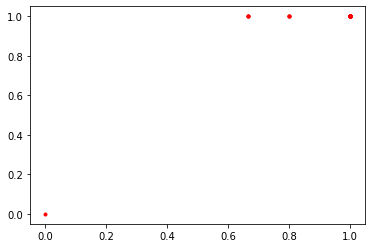

In [131]:
plt.plot(model.TNR_list, model.TPR_list, "r.")